# Сегментация вулканических выбросов по изображению с помощью нейронных сетей


# 1. Problem Statement
Необходимо по снимкам веб камер выделять на изображении участки относящиеся к вулканическим выбросам: парогазовый столб и  лава.

### Libraries and Functions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Common libraries
import os
import random
from glob import glob
from imutils import paths
from os import path
import re
import imageio  

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Visualisation
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
plt.rcParams["axes.grid"] = False

# Modeling Algorithms
import tensorflow as tf
from keras.utils import to_categorical
from keras import backend as K
from keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, recall_score, f1_score, precision_score
from sklearn.metrics import plot_roc_curve 

# Image segmantation
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.morphology import remove_small_objects

print(tf.__version__)
print(tf.executing_eagerly())


2.4.1
True


In [3]:
project_path = '/content/drive/MyDrive/ML/Volcano/'
IMG_SIZE = (256, 256)

IMG_HEIGHT = IMG_SIZE[0]
IMG_WIDTH = IMG_SIZE[1]

class_status = {0: 'alert', 
               1: 'normal'}

class_pillar = {0: '-', 
               1: 'pillar'}

class_lava = {0: '-', 
              1: 'lava'}   

In [5]:
# Загрузка изображения и приведение к общему размеру 
def load_image(path, target_size=IMG_SIZE):
    image = cv2.imread(path)[...,::-1]
    image = cv2.resize(image, target_size)
    return image  

def load_image_io(path):
    # используем imageio, тк cv2 
    # не поддерживает загрузку .gif
    img = imageio.imread(path)
    return cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

def load_image_mask(path):
    # используем imageio, тк cv2 
    # не поддерживает загрузку .gif
    img = cv2.bitwise_not(imageio.imread(path))
    return cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

def binarise(img):
    thr, result = cv2.threshold(img, -1, 1, cv2.THRESH_OTSU)
    return result

# Обработка изображения - размерность не меняется
def gradient_image(src):
    image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    image = cv2.GaussianBlur(image, (3, 3), 0)
    ##laplacian = cv2.Laplacian(image,cv2.CV_64F)
    sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
    abs_grad_x = cv2.convertScaleAbs(sobelx)
    abs_grad_y = cv2.convertScaleAbs(sobely)    
    image = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0) 
    
    return image 

def gradient_image_gray(src):
    scale = 1
    delta = 0
    #ddepth = cv2.CV_16S
    ddepth = cv2.CV_32F
    src = cv2.GaussianBlur(src, (3, 3), 0)
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)  
    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    grad = cv2.cvtColor(grad, cv2.COLOR_GRAY2BGR)
    return grad

# Вычисляем угол и длину вектора градиента
def gradient_image_polar(src,ddepth = cv2.CV_32F, scale = 1, delta = 0 ):
    image = cv2.GaussianBlur(src, (3, 3), 0)
    grad_x = cv2.Sobel(image, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(image, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    g, theta = cv2.cartToPolar(grad_x, grad_y)
    return g, theta

def create_mask(image, image_mask):    #  создаем маску, оставляем только нужный фрагмент, размер изображения не меняется, каналы убираются 
    init_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2GRAY)  

    mask = np.zeros(image.shape[:2],np.uint8)
    mask[init_mask == 255] = 1
    mask[init_mask == 0] = 2 #Guess everything else is background

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    mask, bgdModel, fgdModel = cv2.grabCut(image,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)

    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    mask[mask == 1] = 255
    return mask

# Вывод заданного количества изображений из указанной папки
def show_images(imagePaths, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(imagePaths, 1):
      subplot = fig.add_subplot(nrows, ncols, i)
      subplot.set_title('%s' % path.split('/')[-2])
      img = cv2.imread(path)[...,::-1]
      img = cv2.resize(img, IMG_SIZE)
      plt.imshow(img)


# Вывод заданного количества изображений для генератора
def show_images_gen(generator, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(generator[0][0:nrows*ncols],1) :
      subplot = fig.add_subplot(nrows, ncols, i)
      subplot.set_title(class_status.get(generator[1][i]))
      img = generator[0][i]
      plt.axis('off')
      plt.imshow(img)

# Вывод заданного количества изображений для генератора классов
def show_images_gen_class(generator, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(generator[0][0:nrows*ncols],1) :
      subplot = fig.add_subplot(nrows, ncols, i)
      title = '%s: %s %s' % (class_status.get(generator[1][i]), class_pillar.get(generator[2][i]), class_lava.get(generator[3][i])) 
      subplot.set_title(title)
      img = generator[0][i]
      print('pillar lava clear cloud mist')
      print(generator[4][i])
      plt.axis('off')
      plt.imshow(img)

# Вывод заданного количества изображений для генератора классов  
def show_images_gen_binary_class(generator,  class_name='status', nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(generator[0][0:nrows*ncols],1) :
      subplot = fig.add_subplot(nrows, ncols, i)
      title = ''
      if class_name == 'status': title = '%s' % (class_status.get(generator[1][i]))
      if class_name == 'pillar': title = '%s' % (class_pillar.get(generator[1][i])) 
      if class_name == 'lava':  title = '%s' % (class_lava.get(generator[1][i])) 
      subplot.set_title(title)
      img = generator[0][i]
      plt.axis('off')
      plt.imshow(img)

            

# Вывод изображения заданного количества картинок из пердсказания модели: класс и вероятность отнесения к классу
def show_images_predict(test_files,y_pred, nrows = 1, ncols = 5):
    n_img = nrows*ncols
    fig = plt.figure(figsize=(20, 10))
    for i, (path, score) in enumerate(zip(test_files[0:n_img], y_pred[0:n_img]), 1):
        title = '%s: %s' % (class_status.get(int(round(score[0]))), np.round(score[0],3))
        subplot = fig.add_subplot(nrows, ncols, i)
        subplot.set_title(title, fontsize=8)
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        subplot.imshow(img)
        plt.axis('off')
  
def show_images_predict_mask(test_files,y_pred, nrows = 1, ncols = 5):
    n_img = nrows*ncols

    fig = plt.figure(figsize=(25, 25))
    for i, (path, score) in enumerate(zip(test_files[0:n_img], y_pred[0:n_img]), 1):
        covarage = np.round(np.sum(score)/ pow(256, 2) * 100 , 2) 
        #title = '%s: %s' % (class_status.get(int(round(score[0]))), np.round(score[0],3))
        title = 'cov %s ' % (covarage)
        subplot = fig.add_subplot(nrows, ncols, i)
        subplot.set_title(title, fontsize=8) 
        
        plt.imshow(load_image(path))
        #plt.imshow(score, cmap='gray', alpha=0.9)
        plt.imshow(score, cmap='Greens', alpha=0.5)


# Вывод изображения заданного количества картинок из пердсказания модели: класс и вероятность отнесения к классу
def show_images_predict_binary_class(test_files,y_pred, class_name='status', nrows = 1, ncols = 5):
    n_img = nrows*ncols
    fig = plt.figure(figsize=(20, 10))
    for i, (path, score) in enumerate(zip(test_files[0:n_img], y_pred[0:n_img]), 1):
        subplot = fig.add_subplot(nrows, ncols, i)
        title = ''
        if class_name == 'status': title = 'status: %s' % (np.round(score[0],3))
        if class_name == 'pillar': title = 'pillar: %s' % (np.round(score[0],3)) 
        if class_name == 'lava':  title = 'lava: %s' % (np.round(score[0],3)) 
        subplot.set_title(title, fontsize=8)
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        subplot.imshow(img)
        plt.axis('off')
        
# Вывод изображения заданного количества картинок из пердсказания модели: класс и вероятность отнесения к классу
def show_images_predict_class(test_files,y_pred, nrows = 1, ncols = 5):
    n_img = nrows*ncols
    fig = plt.figure(figsize=(25, 25))
    for i, (path, score) in enumerate(zip(test_files[0:n_img], y_pred[0:n_img]), 1):
        title = 'pillar:%s lava:%s \nclear:%s cloud:%s mist:%s' % (np.round(score[0],3),np.round(score[1],3),  np.round(score[2],3), np.round(score[3],3), np.round(score[4],3))
        subplot = fig.add_subplot(nrows, ncols, i)
        subplot.set_title(title, fontsize=8)
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        subplot.imshow(img)
        plt.axis('off')

def plot_model_history(model_history):
      # Getting the accuracy and loss
      acc = model_history.history['accuracy']
      val_acc = model_history.history['val_accuracy']
      loss = model_history.history['loss']
      val_loss = model_history.history['val_loss']
      # Plotting the accuracy
      epochs = range(len(acc))

      fig = plt.figure(figsize=(16, 6))
      subplot = fig.add_subplot(1, 2, 1)
      subplot.set_title('accuracy')
      plt.plot(epochs, acc, '-o', label='Training accuracy')
      plt.plot(epochs, val_acc, '-', label='Validation accuracy')
      plt.title('Training and validation accuracy')
      plt.grid(linestyle='--')
      plt.legend()

      subplot = fig.add_subplot(1, 2, 2)
      subplot.set_title('loss')
      plt.plot(epochs, loss, '-o', label='Training Loss' )
      plt.plot(epochs, val_loss, '-', label='Validation Loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.grid(linestyle='--')
      plt.show()

def plot_model_history_dice(model_history):
      acc = model_history.history['binary_crossentropy']
      val_acc = model_history.history['dice_coef']
      loss = model_history.history['loss']
      epochs = range(len(acc))

      fig = plt.figure(figsize=(16, 6))
      subplot = fig.add_subplot(1, 2, 1)
      subplot.set_title('accuracy')
      plt.plot(epochs, acc, '-o', label='Training binary crossentropy')
      plt.plot(epochs, val_acc, '-', label='Training dice coef')
      plt.title('Binary crossentropy and dice coef')
      plt.grid(linestyle='--')
      plt.legend()

      subplot = fig.add_subplot(1, 2, 2)
      subplot.set_title('loss')
      plt.plot(epochs, loss, '-o', label='Training Loss' )
      plt.title('Training loss')
      plt.legend()
      plt.grid(linestyle='--')
      plt.show()


# функция-генератор загрузки тестовых изображений с диска  steps=len(imagePaths_test))
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

def test_img_generator(test_paths):   #  
    for path in test_paths:
        yield np.array([load_image(path)])
        

# функция используется в генераторах при загрузке изображений для определения класса для обучающей выборке по имени папки и файла
def encode(files_path):
    y_visible = []   # класс видимость категориальный признак (mist, cloud,clear)   
    y_pillar = []    # класс тип активности: 1 - парогазовый столб
    y_lava = []      # класс тип активности: 1 - лава
    y_activity = []  # обощенные признаки всех классов  - pillar	lava	visible__clear	visible__cloud	visible__mist
    for path in files_path:
              result_vis = re.match(r'[a-zA-Z]+', path.split(os.path.sep)[-1])  
              y_visible.append( result_vis.group(0))

              result = re.split(r'\+', path.split(os.path.sep)[-1])
              if result[1] == 'pillar': y_pillar.append(1) 
              else: y_pillar.append(0)
              if result[2] == 'lava': y_lava.append(1) 
              else: y_lava.append(0) 

              y_activity = pd.DataFrame()
              y_activity['pillar'] = y_pillar
              y_activity['lava'] = y_lava
              y_activity = y_activity.join(pd.get_dummies(y_visible, prefix='visible_'))
              y_activity = np.array(y_activity)
              
    return y_pillar, y_lava, y_activity

# функция-генератор загрузки обучающих данных с диска
def fit_generator_binary_class(files, class_name='status', batch_size=24):   
    batch_size = min(batch_size, len(files))
    while True:
        random.shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y_status = np.array([1 if  path.split(os.path.sep)[-2] == 'normal' else 0    
                          for path in files[i:j]])

            y_pillar, y_lava, y_activity = encode(files[i:j])

            if class_name == 'status': y = y_status
            if class_name == 'pillar': y = np.array(y_pillar)
            if class_name == 'lava':   y = np.array(y_lava)

            yield (x, y)
  
# функция-генератор загрузки обучающих данных с диска
def fit_generator_classes(files, batch_size=24):   
    batch_size = min(batch_size, len(files))
    while True:
        random.shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1 if  path.split(os.path.sep)[-2] == 'normal' else 0    # y - основной класс 1 - normal, 0 - alert
                          for path in files[i:j]])

            y_pillar, y_lava, y_activity = encode(files[i:j])

            yield (x, np.array(y_activity))

# функция-генератор загрузки обучающих данных с диска для изображений (X) и масок (Y)
def fit_generator_mask(train_img_paths, train_mask_paths, batch_size=6):   
    batch_size = min(batch_size, len(train_img_paths))
    while True:
        #random.shuffle(train_img_paths,seed =42)
        for k in range(len(train_img_paths) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(train_img_paths):
                j = - j % len(train_img_paths)
            x = np.array([load_image(path) for path in train_img_paths[i:j]])

            y = np.array([binarise(load_image_mask(path)) for path in train_mask_paths[i:j]])
            # combine generators into one which yields image and masks
            train_generator = zip(x, y)   #проверить вместо x y
            yield (x, y)
            

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_ = tf.cast( tf.reshape(y_true, [-1]), tf.float32)
    y_pred_ = tf.cast( tf.reshape(y_pred, [-1]), tf.float32)
    y_true_f = K.flatten(y_true_)
    y_pred_f = K.flatten(y_pred_)
    intersection = K.sum(y_true_f * y_pred_f)
    return  (2. * intersection + smooth) /(K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.2 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def show_mask_gradient(img, subplot):
  #mask = np.where((img<=0.00001),0,1).astype('uint8')    # обнуляем значения меньше заданного уровня, т.е очищаем картинку от малой вероятности принадлежности к классу "маска"
  

  #mask1 = np.where((img<=0.00001),0,1).astype('uint8')
  #mask1 = np.where((img<=0.0001),0,1).astype('uint8')
  #mask2 = cv2.bitwise_not(mask1) 
  #mask3 = binarise(mask1) 

  center = np.where((img>=0.8),1,0).astype('uint8') 
  #center_full = ndi.label(remove_small_objects(center, 5))[0]  # чтобы добавить в градиент надо максимальную площадь находить

  edges = canny(img)    
  fill_edge = ndi.binary_fill_holes(edges)
  edges_full = ndi.label(remove_small_objects(fill_edge, 5))[0]

  X,Y = np.meshgrid(np.arange(256), np.arange(256))

  array =np.array(center)
  dy, dx = np.gradient(center)

  n = 3
  plt.quiver(X[::n,::n],Y[::n,::n],-dx[::n,::n], -dy[::n,::n], 
           np.sqrt(dx[::n,::n]**2+dy[::n,::n]**2),
           units="xy", scale=0.08, cmap="Reds", alpha=0.5)
  
  plt.text(0, 10,np.round((np.sum(img)/ pow(256, 2)) * 100 , 3))
  plt.text(240, 10,np.round(np.sum(center)/ np.sum(img) * 100 , 3))

  plt.imshow(edges_full, cmap='Reds', alpha=0.5)

  #print(np.round((np.sum(img)/ pow(256, 2)) * 100 , 3) )  # площадь класса % картинки слева вверху
  #print(np.round(np.sum(center)/ np.sum(img) * 100 , 3) )   # площадь очага % маски справа вверху


def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap='Blues') # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)


# 2. Data Understanding

Набор данных - фотографии вуканов, разделенные на несколько классов:

•	класс состояние: 

'**alert**' (0) -  на фото зафиксирована любая активность на вулкане: парогазовый столб, взрыв, потоки лавы, 

'**normal**' (1) - нормальное состояние, никакой активности вулкана не отмечается, либо видимость не позволяет определить более точно. 

•	класс видимость: 

*	**clear** – ясно 
*	**cloud** – облачно 
*	**mist** – туман, сумерки, плохая видимость

•	класс выбросов - **парогазовый столб** (шлейф): 

* 0 / 1 – не определено / определено наличие парогазовых выбросов

•	класс выбросов -  **лава**:

*	 0 / 1 - не определено / определено наличие лавовых потоков.


### 2.1 Загрузка данных

Подготовим три датасета. 
Датасеты для обучения и вализации разбиты на классы. Класс соответствует названию папки.
Датасет для теста не разбит по классам.
Так как для сегментации необходим набор данных с масками изображений, исходные изображения загружаем из отдельных папок.

In [6]:
# данные читаем функцией-генератором

imagePaths_train = sorted(list(paths.list_images(path.join(project_path,'data/processed/train'))))
imagePaths_validation = sorted(list(paths.list_images(path.join(project_path,'data/processed/test'))))
imagePaths_test = sorted(list(paths.list_images(path.join(project_path,'data/raw/img'))))


random.shuffle(imagePaths_train)  # перемешиваем обучающую выборку
random.shuffle(imagePaths_validation)

# бинарная классификация
validation_ds_lava = fit_generator_binary_class(imagePaths_train, 'lava')
train_ds_lava = fit_generator_binary_class(imagePaths_validation, 'lava')  

validation_ds_pillar = fit_generator_binary_class(imagePaths_train, 'pillar')
train_ds_pillar = fit_generator_binary_class(imagePaths_validation, 'pillar')  

test_ds = predict_generator(imagePaths_test)


train_img_paths_pillar = sorted(list(paths.list_images(path.join(project_path,'data/processed/train_pillar'))))   # обучающая выборка
train_mask_paths_pillar = sorted(list(paths.list_images(path.join(project_path,'data/processed/mask_pillar'))))   # маска для обучающй выборки (названия и количество файлов должны совпадать)

train_img_paths_lava = sorted(list(paths.list_images(path.join(project_path,'data/processed/train_lava'))))   # обучающая выборка
train_mask_paths_lava = sorted(list(paths.list_images(path.join(project_path,'data/processed/mask_lava'))))   # маска для обучающй выборки (названия и количество файлов должны совпадать)

img_pillar_ds = fit_generator_mask(train_img_paths_pillar, train_mask_paths_pillar)
img_lava_ds = fit_generator_mask(train_img_paths_lava, train_mask_paths_lava)



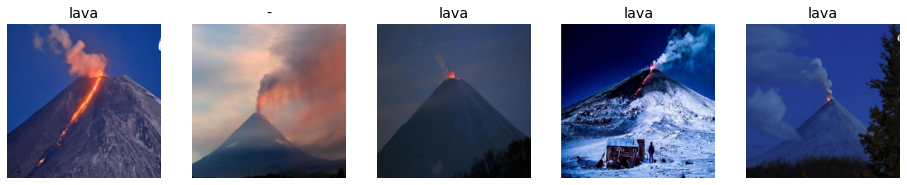

In [ ]:
show_images_gen_binary_class(next(train_ds_lava), 'lava' ,1,5)

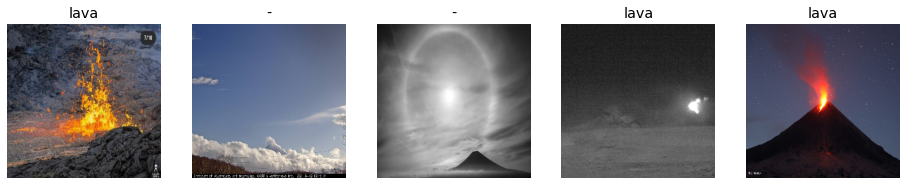

In [ ]:
show_images_gen_binary_class(next(validation_ds_lava), 'lava' ,1,5)

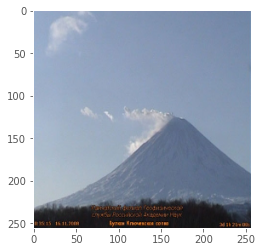

In [ ]:
image = next(test_ds)[0]
plt.imshow(image)

Загрузка данных для подготовки маски изображений

In [7]:
next(img_pillar_ds)[0].shape

(6, 256, 256, 3)

In [8]:
next(img_lava_ds)[0].shape

(6, 256, 256, 3)

## 2.2 Анализ данных

Алгоритм GrabCut

Будем применять алгоритм [GrabCut](https://en.wikipedia.org/wiki/GrabCut) для подготовки масок изображения из обущающей выборки. Подготовка выполняется в два этапа. Cначала в редакторе изображения вырезаем все  кроме нужного сегмента (выделить-обратить-удалить).
Загружаем предварительно размеченные области, приводим к нужному размеру, уточняем с помощью алгоритма область маски, бинаризуем и сохраняем для обучения.



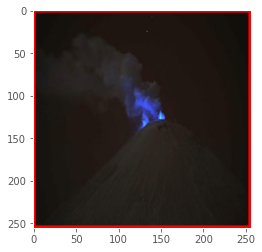

In [ ]:
# прямоугльником задаем область принадлежащую объекту
(h, w) = image.shape[:2]  # размеры изображения
(cX, cY) = (int(w * 0.5), int(h * 0.5))  # координаты центра изображения
(axesX, axesY) = (int(w * 0.45) // 2, int(h * 0.25) // 2)
RECT = (axesX,axesY,w - axesX,h -axesY)
RECT = (0,0,255,255)

# визуализируем выделенную область
x1, y1, x2, y2 = RECT
tmp = cv2.rectangle(np.copy(image), (x1,y1), (x2,y2), (0,0,255), 3)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

# выделяем память под результат работы алгоритма
mask = np.zeros(image.shape[:2], np.uint8)

# выделяем память необходимую для работы алгоритма
bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

grad = gradient_image_gray(image)
cv2.grabCut(grad, mask, RECT, bgdModel, fgdModel, 18, cv2.GC_INIT_WITH_RECT);
mask2 = np.where((mask==0)|(mask==2), 0, 1).astype('uint8')
result = image * mask2[:,:,np.newaxis]

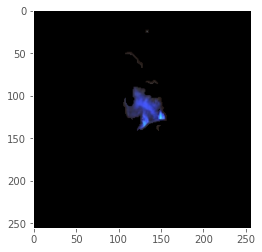

In [ ]:
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))


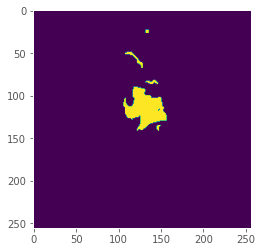

In [ ]:
plt.imshow(mask2)

#  3.  Data Preparation

## 3.1 Обработка масок изображений


In [ ]:
train_files = sorted(list(paths.list_images(path.join(project_path,'data/processed/train'))))
valid_files = sorted(list(paths.list_images(path.join(project_path,'data/processed/test'))))
hand_mask_pillar_files = sorted(list(paths.list_images(path.join(project_path,'data/processed/hand_mask_pillar'))))
hand_mask_lava_files = sorted(list(paths.list_images(path.join(project_path,'data/processed/hand_mask_lava'))))

In [ ]:
for path_image, path_m in zip(train_files,hand_mask_pillar_files) :
      result = re.split(r'\+', path_image.split(os.path.sep)[-1])
      if result[1] == 'pillar':
        path_mask = path.join(project_path,'data/processed/mask_pillar')
        image_full = load_image(path_image)
        image_mask = load_image(path_m)
        filename = re.split(r'\.jpg', path_image.split(os.path.sep)[-1])[0]+'.png'
        p = os.path.sep.join([path_mask, filename])
        cv2.imwrite(p,create_mask(image_full,image_mask))

for path_image, path_m in zip(train_files,hand_mask_lava_files) :
      result = re.split(r'\+', path_image.split(os.path.sep)[-1])
      if result[2] == 'lava': 
        path_mask = path.join(project_path,'data/processed/mask_lava')
        image_full = load_image(path_image)
        image_mask = load_image(path_m)
        filename = re.split(r'\.jpg', path_image.split(os.path.sep)[-1])[0]+'.png'
        p = os.path.sep.join([path_mask, filename])
        cv2.imwrite(p,create_mask(image_full,image_mask))


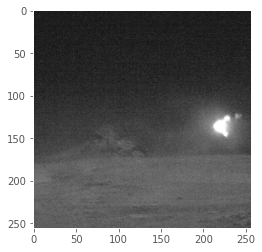

In [ ]:
plt.imshow(image_full)

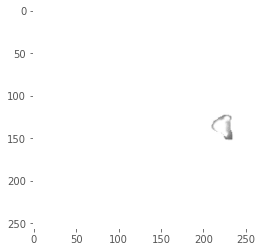

In [ ]:
plt.imshow(image_mask)

# 4. Modeling 

Прежде чем решать задачу сегментации определим зафиксированы или нет выросы на вулкане, т.е. решим задачу бинарной классификации.


## 4.1 Бинарная классификация ResNet50

In [89]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3), classes=2) 

for layer in base_model.layers:
    layer.trainable = False


x = base_model.layers[-5].output

x = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(.2, input_shape=(2,))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Dense(32, activation = 'relu')(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1, 
                          activation='sigmoid',  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

ResNet_model_lava =  tf.keras.Model(inputs = base_model.input, outputs=x)

ResNet_model_lava.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
ResNet_model_lava.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [90]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_ResNet_lava = ResNet_model_lava.fit(train_ds_lava, epochs=30, steps_per_epoch=80, callbacks=[es_callback], validation_data=validation_ds_lava, validation_steps=2)  

Epoch 1/30
80/80 [==============================] - 64s 765ms/step - loss: 0.0466 - accuracy: 0.9401 - val_loss: 0.0604 - val_accuracy: 0.9375
Epoch 2/30
80/80 [==============================] - 36s 457ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0701 - val_accuracy: 0.9167
Epoch 3/30
80/80 [==============================] - 34s 428ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0693 - val_accuracy: 0.9167
Epoch 4/30
80/80 [==============================] - 34s 425ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0630 - val_accuracy: 0.9167


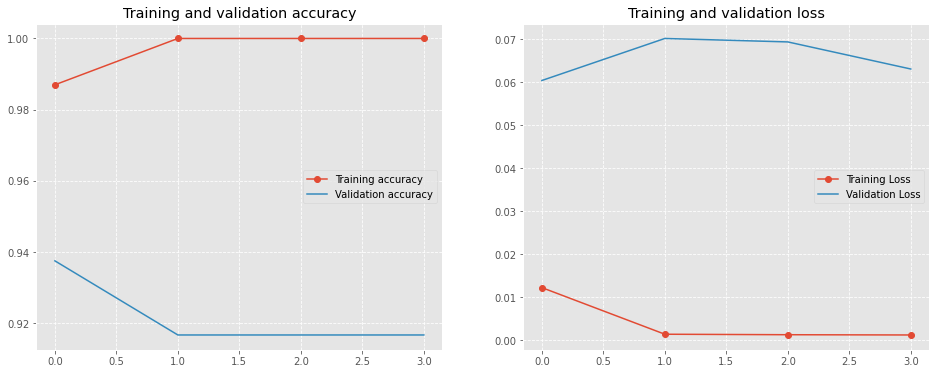

In [91]:
plot_model_history(history_ResNet_lava)

In [92]:
test_pred_ResNet_model_lava = ResNet_model_lava.predict(predict_generator(imagePaths_test), steps=len(imagePaths_test))
test_pred_ResNet_model_lava

array([[4.0695917e-02],
       [9.9971098e-01],
       [4.5839813e-02],
       [5.3480804e-02],
       [9.9789292e-01],
       [1.9409706e-01],
       [9.9214399e-01],
       [8.5528806e-02],
       [1.1047593e-01],
       [9.5694917e-01],
       [3.7501904e-03],
       [1.9596461e-03],
       [2.8573491e-03],
       [2.3332639e-03],
       [4.2401836e-03],
       [3.7041458e-03],
       [3.1548310e-03],
       [3.0694182e-03],
       [1.4211845e-03],
       [1.1704220e-03],
       [6.4298720e-04],
       [3.3895867e-03],
       [4.0238881e-03],
       [5.5972324e-03],
       [4.7192941e-03],
       [4.3470971e-03],
       [2.4377357e-03],
       [1.0491774e-02],
       [5.3800391e-03],
       [1.4777994e-03],
       [6.4630407e-01],
       [9.9824703e-01],
       [1.6286975e-01],
       [2.0654757e-01],
       [9.9962938e-01],
       [9.9799430e-01],
       [9.4270134e-01],
       [1.8165542e-01],
       [2.4200156e-03],
       [9.9920183e-01],
       [2.4573423e-02],
       [2.190408

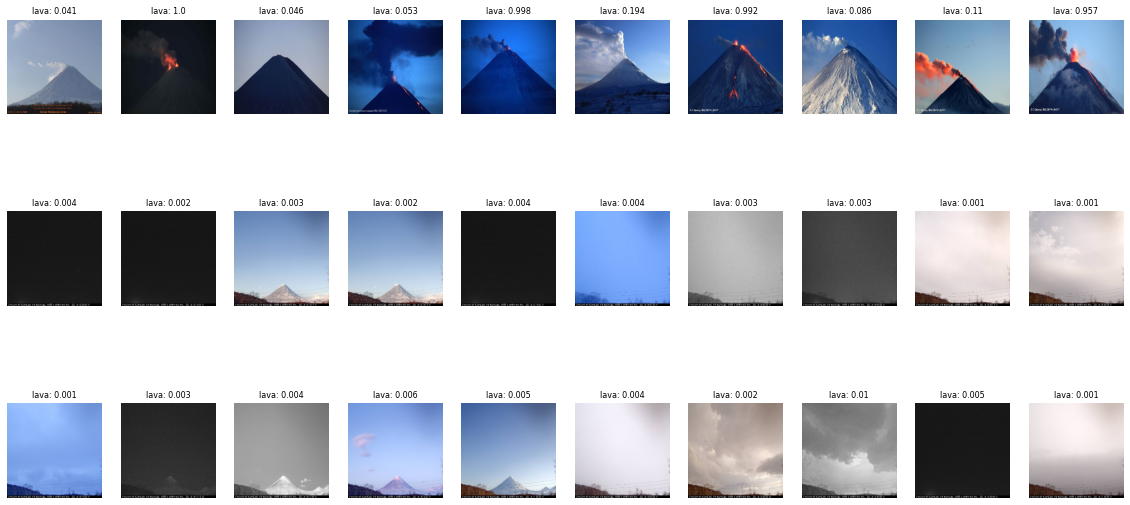

In [93]:
show_images_predict_binary_class(imagePaths_test,test_pred_ResNet_model_lava, 'lava', 3,  10)

In [ ]:
ResNet_model_pillar =  tf.keras.Model(inputs = base_model.input, outputs=x)

ResNet_model_pillar.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])

history_ResNet_model_pillar = ResNet_model_pillar.fit(train_ds_pillar, epochs=30, steps_per_epoch=80, callbacks=[es_callback], validation_data=validation_ds_pillar, validation_steps=2)  




Epoch 1/30
80/80 [==============================] - 36s 420ms/step - loss: 0.1103 - accuracy: 0.8848 - val_loss: 0.2511 - val_accuracy: 0.7292
Epoch 2/30
80/80 [==============================] - 32s 406ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2676 - val_accuracy: 0.6875
Epoch 3/30
80/80 [==============================] - 32s 407ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2189 - val_accuracy: 0.7083
Epoch 4/30
80/80 [==============================] - 32s 405ms/step - loss: 9.5623e-04 - accuracy: 1.0000 - val_loss: 0.2418 - val_accuracy: 0.6875
Epoch 5/30
80/80 [==============================] - 33s 414ms/step - loss: 9.2217e-04 - accuracy: 1.0000 - val_loss: 0.2441 - val_accuracy: 0.6250
Epoch 6/30
80/80 [==============================] - 33s 420ms/step - loss: 8.9345e-04 - accuracy: 1.0000 - val_loss: 0.2050 - val_accuracy: 0.6875
Epoch 7/30
80/80 [==============================] - 32s 405ms/step - loss: 8.6397e-04 - accuracy: 1.0000 - val_loss: 0.2409 - val_

In [73]:
test_pred_ResNet_model_pillar = ResNet_model_pillar.predict(predict_generator(imagePaths_test), steps=len(imagePaths_test))
test_pred_ResNet_model_pillar

array([[0.17418082],
       [0.01474962],
       [0.05137746],
       [0.901118  ],
       [0.17280251],
       [0.977079  ],
       [0.337305  ],
       [0.01397919],
       [0.96431845],
       [0.8749265 ],
       [0.00183169],
       [0.00169183],
       [0.99355763],
       [0.99522215],
       [0.00218042],
       [0.00246549],
       [0.00381537],
       [0.00216007],
       [0.00243584],
       [0.00173047],
       [0.00217104],
       [0.00181254],
       [0.8922008 ],
       [0.6393441 ],
       [0.98485583],
       [0.00277036],
       [0.00447151],
       [0.00672229],
       [0.00258935],
       [0.00238506],
       [0.2696657 ],
       [0.6956241 ],
       [0.93016297],
       [0.20320956],
       [0.09314708],
       [0.00623155],
       [0.05910198],
       [0.00761941],
       [0.99914217],
       [0.73425865],
       [0.0083505 ],
       [0.00401375],
       [0.00201408],
       [0.0027238 ],
       [0.02243457]], dtype=float32)

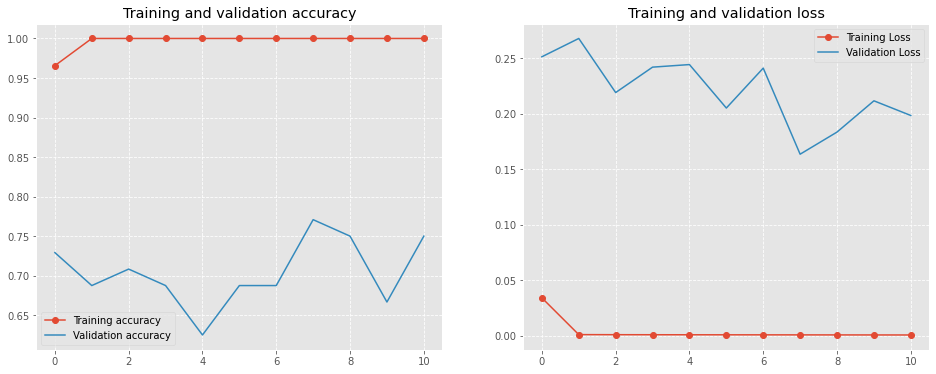

In [ ]:
plot_model_history(history_ResNet_model_pillar)

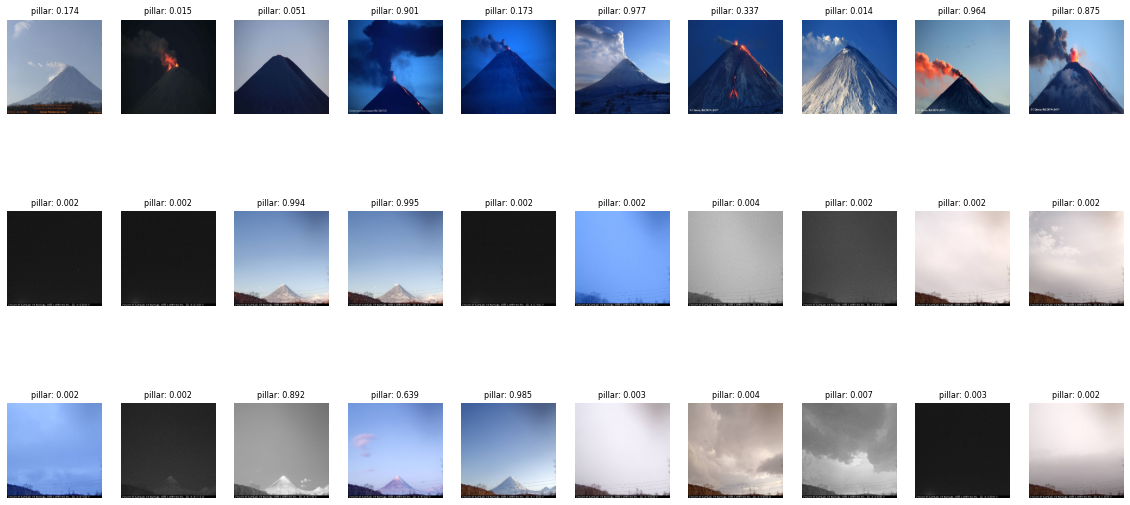

In [ ]:
show_images_predict_binary_class(imagePaths_test,test_pred_ResNet_model_pillar, 'pillar', 3,  10)

In [94]:
ResNet_model_lava.save(path.join(project_path,'models/resnet_model_lava.h5'))
ResNet_model_pillar.save(path.join(project_path,'models/resnet_model_pillar.h5'))

## 4.2 Бинарная классификация VGG

In [95]:
base_model_VGG = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3), classes=2) 

for layer in base_model_VGG.layers:
    layer.trainable = False

x = base_model_VGG.layers[-1].output

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1,  
                          activation='sigmoid',   
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

VGG_model_lava =  tf.keras.Model(inputs = base_model_VGG.input, outputs=x)

VGG_model_lava.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_VGG_lava = VGG_model_lava.fit(train_ds_lava, epochs=30, steps_per_epoch=80, callbacks=[es_callback], validation_data=validation_ds_lava, validation_steps=2)  

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/30
80/80 [==============================] - 44s 461ms/step - loss: 0.0394 - accuracy: 0.9677 - val_loss: 0.2867 - val_accuracy: 0.7083
Epoch 2/30
80/80 [==============================] - 36s 448ms/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.1483 - val_accuracy: 0.8333
Epoch 3/30
80/80 [==============================] - 36s 449ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.2270 - val_accuracy: 0.7708
Epoch 4/30
80/80 [==============================] - 36s 453ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.2580 - val_accuracy: 0.7500
Epoch 5/30
80/80 [==============================] - 36s 453ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.2400 - val_accuracy: 0.7292


In [ ]:
VGG_model_lava.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

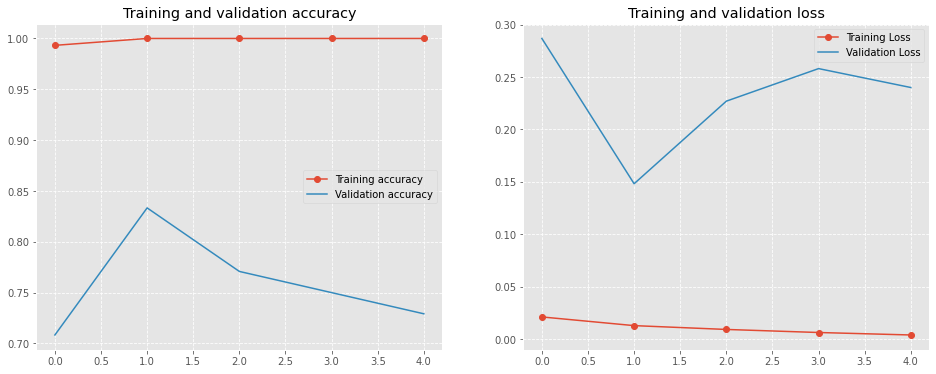

In [96]:
plot_model_history(history_VGG_lava)

In [97]:
test_pred_VGG_model_lava = VGG_model_lava.predict(predict_generator(imagePaths_test), steps=len(imagePaths_test))
test_pred_VGG_model_lava

array([[6.5984100e-01],
       [9.9245983e-01],
       [4.2178479e-01],
       [9.2833924e-01],
       [9.8814875e-01],
       [9.9945015e-01],
       [9.9995458e-01],
       [9.9999261e-01],
       [7.9456693e-01],
       [9.9633336e-01],
       [6.6907780e-04],
       [5.9932965e-04],
       [3.6000467e-03],
       [2.4220911e-03],
       [4.8963091e-04],
       [2.6504591e-03],
       [2.0318301e-03],
       [1.8330179e-03],
       [3.8566038e-03],
       [6.4549521e-03],
       [2.5844725e-03],
       [1.4081447e-03],
       [7.8865327e-04],
       [5.6328448e-03],
       [1.0849708e-02],
       [3.3158988e-03],
       [1.1492022e-02],
       [8.2260976e-03],
       [8.6410949e-04],
       [1.8315137e-03],
       [9.9655664e-01],
       [9.9959964e-01],
       [9.9248838e-01],
       [2.8762954e-01],
       [9.9998188e-01],
       [9.7093570e-01],
       [9.9831533e-01],
       [2.7966821e-01],
       [2.2489203e-03],
       [9.9991667e-01],
       [7.1534574e-01],
       [9.641703

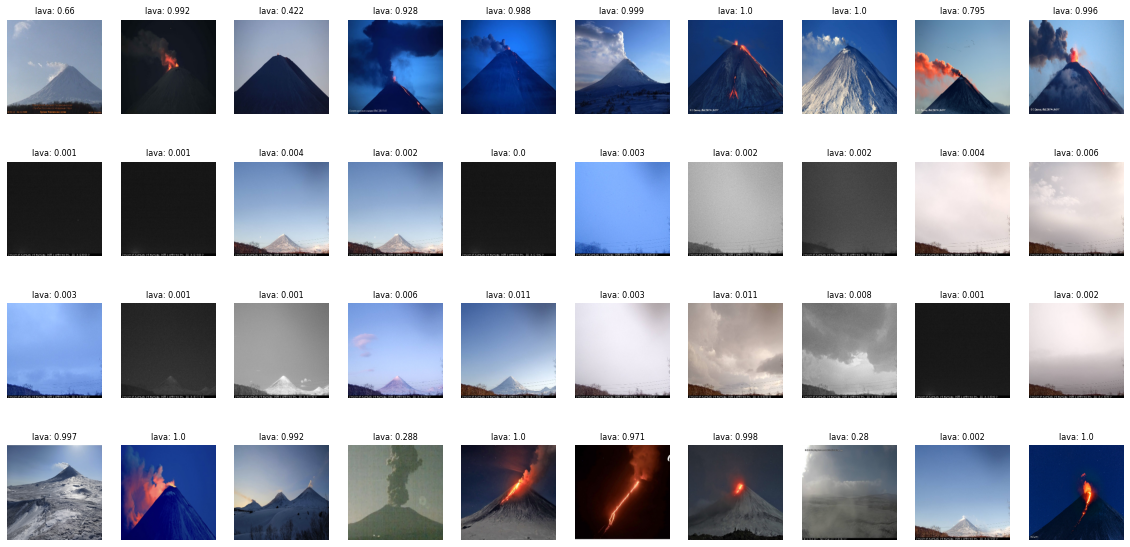

In [99]:
show_images_predict_binary_class(imagePaths_test,test_pred_VGG_model_lava, 'lava', 4,  10)

In [ ]:
VGG_model_pillar =  tf.keras.Model(inputs = base_model_VGG.input, outputs=x)

VGG_model_pillar.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_VGG_pillar = VGG_model_pillar.fit(train_ds_pillar, epochs=30, steps_per_epoch=80, callbacks=[es_callback], validation_data=validation_ds_pillar, validation_steps=2)  


Epoch 1/30
80/80 [==============================] - 35s 430ms/step - loss: 0.0514 - accuracy: 0.9496 - val_loss: 0.3888 - val_accuracy: 0.5833
Epoch 2/30
80/80 [==============================] - 34s 430ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.2305 - val_accuracy: 0.7083
Epoch 3/30
80/80 [==============================] - 34s 429ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.3125 - val_accuracy: 0.6667
Epoch 4/30
80/80 [==============================] - 34s 429ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.2125 - val_accuracy: 0.6875
Epoch 5/30
80/80 [==============================] - 34s 430ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2402 - val_accuracy: 0.7083
Epoch 6/30
80/80 [==============================] - 34s 427ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2448 - val_accuracy: 0.6667
Epoch 7/30
80/80 [==============================] - 34s 429ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2346 - val_accuracy: 0.6250

In [75]:

test_pred_VGG_model_pillar = VGG_model_pillar.predict(predict_generator(imagePaths_test), steps=len(imagePaths_test))

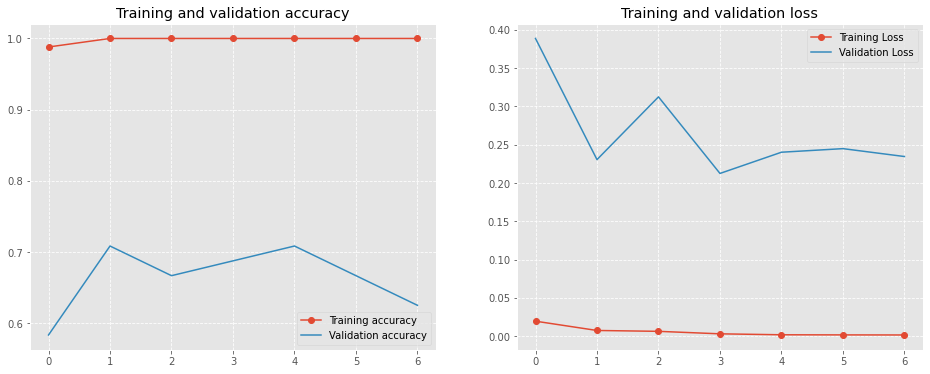

In [ ]:
plot_model_history(history_VGG_pillar)

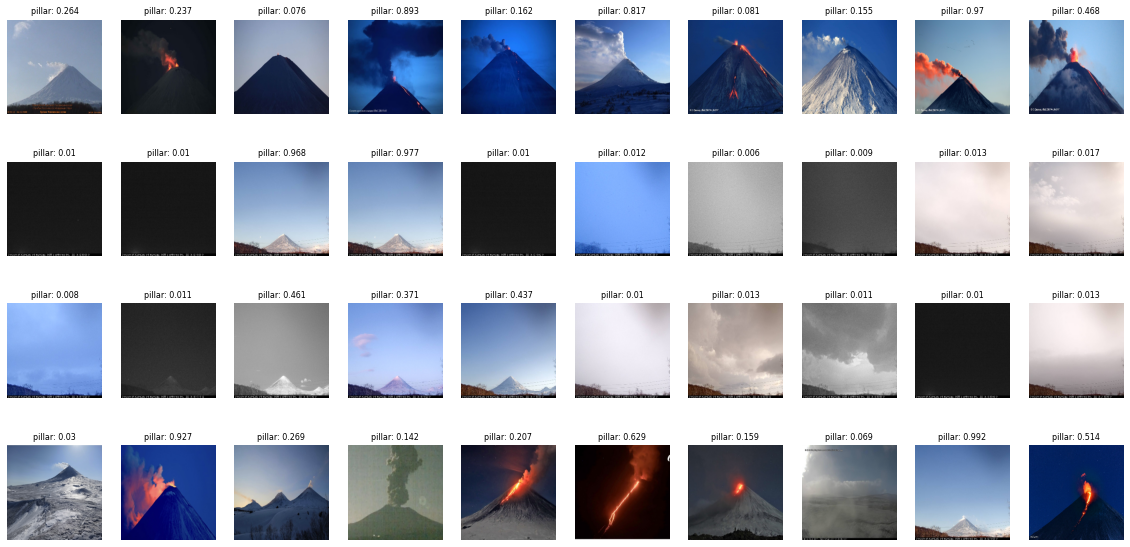

In [ ]:
show_images_predict_binary_class(imagePaths_test,test_pred_VGG_model_pillar, 'pillar', 4,  10)

In [98]:
VGG_model_lava.save(path.join(project_path,'models/vgg_model_lava.h5'))
#VGG_model_pillar.save(path.join(project_path,'models/vgg_model_pillar.h5'))


## 4.3 U-net сегментация

[Сеть](https://ru.wikipedia.org/wiki/U-Net) содержит сверточную (слева) и разверточную части (справа).

Сверточная часть похожа на обычную свёрточную сеть, он содержит два подряд свёрточных слоя 3x3, после которых идет слой ReLU и пулинг с функцией максимума 2×2 с шагом 2.

Каждый шаг разверточной части содержит слой, обратный пулингу, который расширяет карту признаков, после которого следует свертка 2x2, которая уменьшает количество каналов признаков. После идет конкатенация с соответствующим образом обрезанной картой признаков из сжимающего пути и две свертки 3x3, после каждой из которой идет ReLU. Обрезка нужна из-за того, что мы теряем пограничные пиксели в каждой свёртке. На последнем слое свертка 1x1 используется для приведения каждого 64-компонентного вектора признаков до требуемого количества классов.

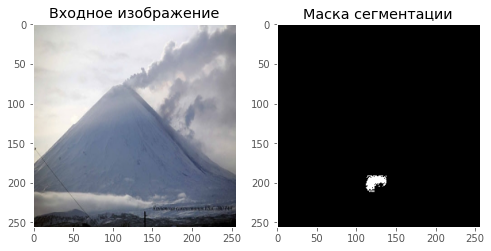

In [ ]:
# проверка датасета
test_gen = next(img_pillar_ds)

plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
plt.title('Входное изображение')
plt.imshow(test_gen[0][1]);

plt.subplot(1, 2, 2)
plt.title('Маска сегментации')
plt.imshow(test_gen[1][1], cmap='gray');

In [ ]:
test_gen[1]

array([[[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   

In [27]:
# Base layers U-net model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)


Сегментация шлейфа

In [28]:
unet_model_pillar = tf.keras.Model(inputs=[inputs], outputs=[conv10])

unet_model_pillar.compile(tf.keras.optimizers.Adam(lr=1e-4),
              bce_dice_loss,
              metrics=[tf.keras.losses.binary_crossentropy, dice_coef])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history_unet_model_pillar = unet_model_pillar.fit(img_pillar_ds, batch_size=3, epochs=30, steps_per_epoch = 80 , callbacks=[es_callback],validation_steps=2)  

Epoch 1/30
80/80 [==============================] - 23s 218ms/step - loss: -0.0067 - binary_crossentropy: 0.8684 - dice_coef: 0.1803
Epoch 2/30
80/80 [==============================] - 13s 167ms/step - loss: -0.3947 - binary_crossentropy: 0.4594 - dice_coef: 0.4865
Epoch 3/30
80/80 [==============================] - 13s 167ms/step - loss: -0.6283 - binary_crossentropy: 0.2942 - dice_coef: 0.6872
Epoch 4/30
80/80 [==============================] - 13s 167ms/step - loss: -0.7500 - binary_crossentropy: 0.2214 - dice_coef: 0.7942
Epoch 5/30
80/80 [==============================] - 13s 167ms/step - loss: -0.8494 - binary_crossentropy: 0.1397 - dice_coef: 0.8774
Epoch 6/30
80/80 [==============================] - 13s 166ms/step - loss: -0.9055 - binary_crossentropy: 0.0866 - dice_coef: 0.9229
Epoch 7/30
80/80 [==============================] - 13s 168ms/step - loss: -0.8595 - binary_crossentropy: 0.1281 - dice_coef: 0.8851
Epoch 8/30
80/80 [==============================] - 13s 167ms/step - 

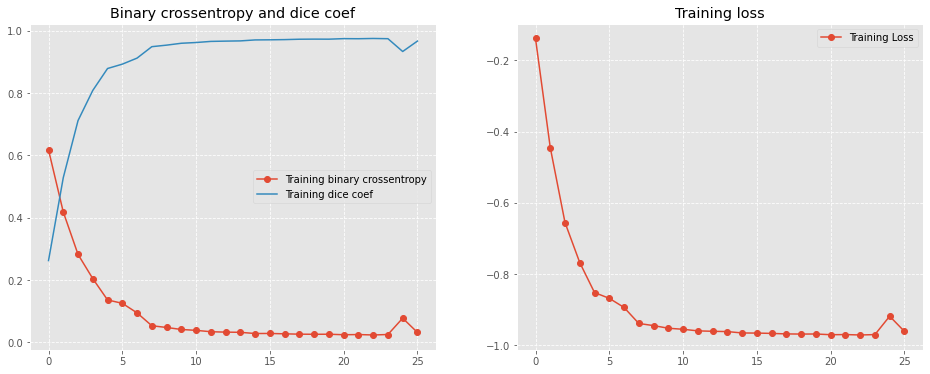

In [29]:
plot_model_history_dice(history_unet_model_pillar)

In [30]:
test_pred_unet_model_pillar = unet_model_pillar.predict(predict_generator(imagePaths_test), steps=len(imagePaths_test))
test_pred_unet_model_pillar = np.squeeze(test_pred_unet_model_pillar)

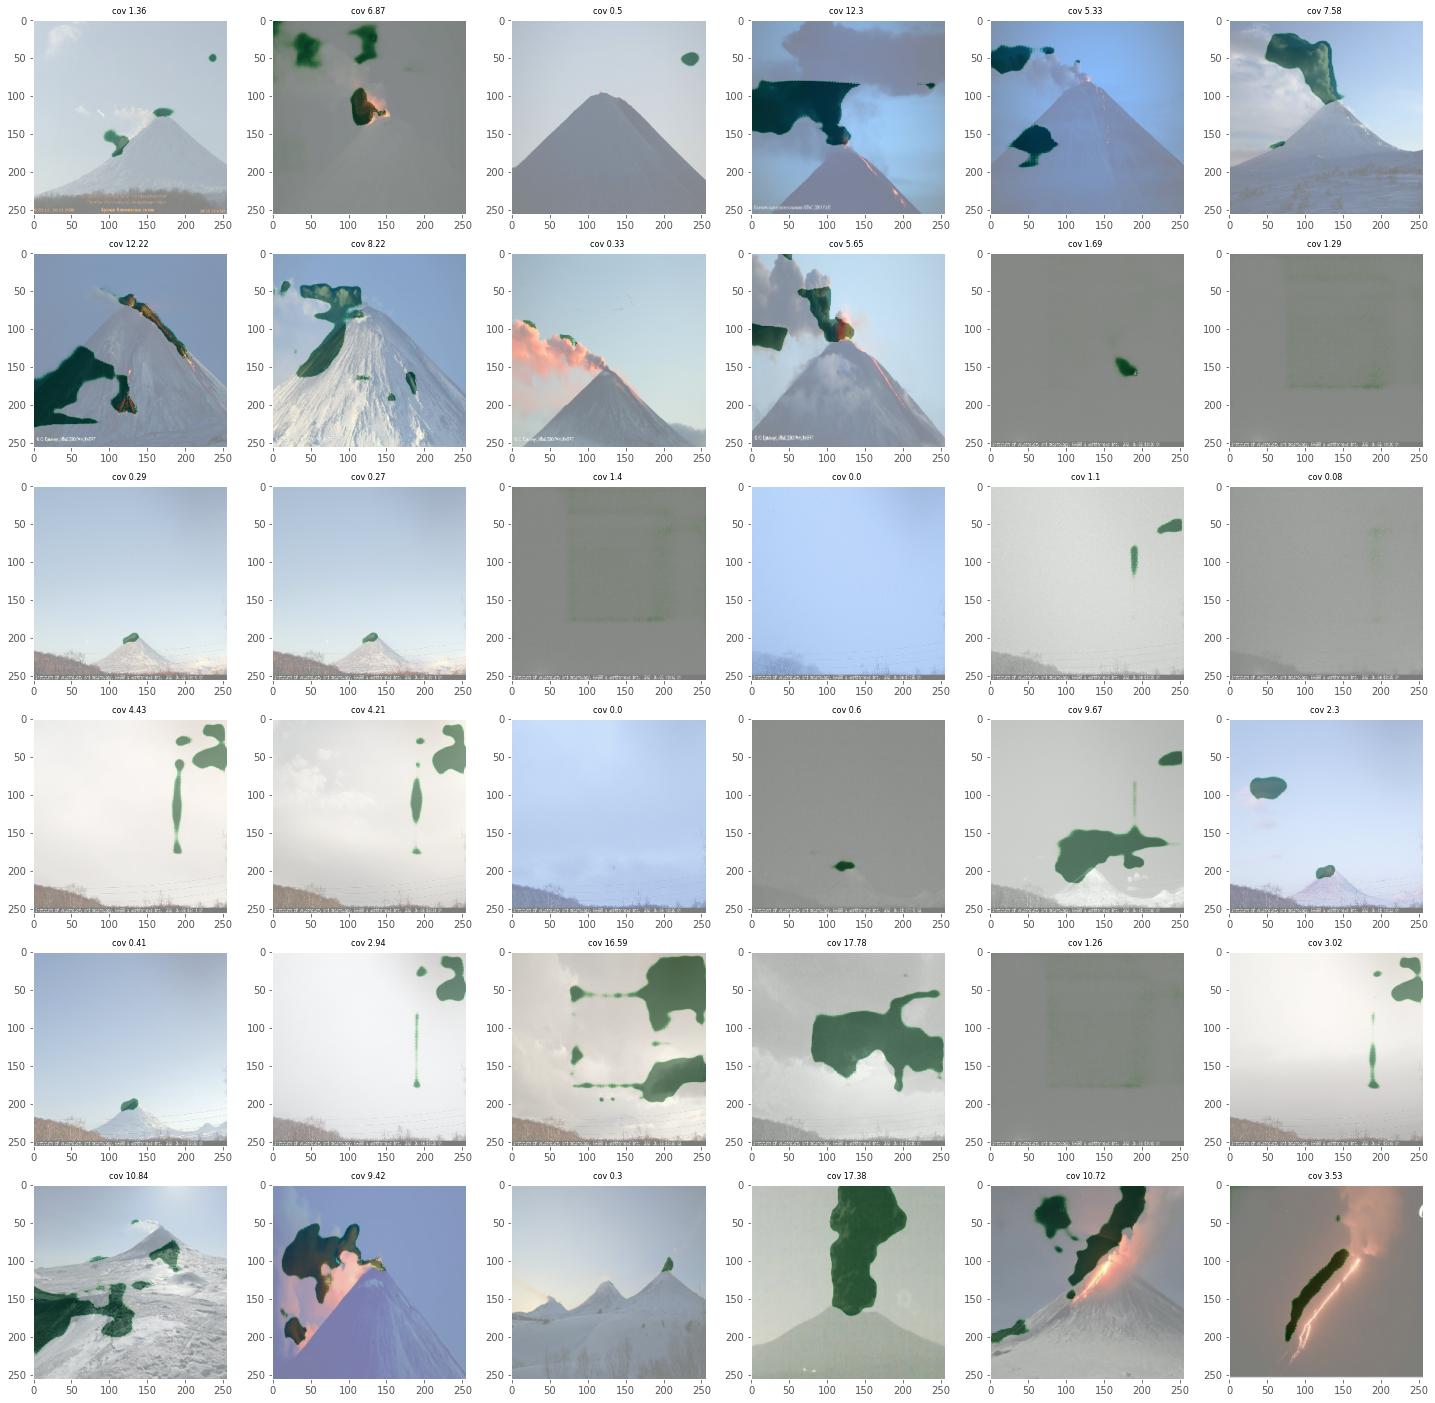

In [31]:
show_images_predict_mask(imagePaths_test,test_pred_unet_model_pillar, 6, 6)

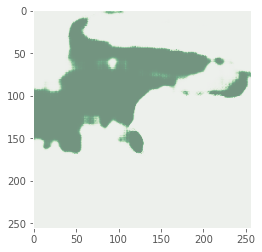

In [ ]:
plt.imshow(test_pred_unet_model_pillar[3],cmap="Greens", alpha=0.5)

Сегментация участков с лавой

In [ ]:
unet_model_lava = tf.keras.Model(inputs=[inputs], outputs=[conv10])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

unet_model_lava.compile(tf.keras.optimizers.Adam(lr=1e-4),
              bce_dice_loss,
              metrics=[tf.keras.losses.binary_crossentropy, dice_coef])

In [ ]:
history_unet_model_lava = unet_model_lava.fit(img_lava_ds, batch_size=3, epochs=30, steps_per_epoch = 80 , callbacks=[es_callback],validation_steps=2)  

Epoch 1/30
80/80 [==============================] - 16s 179ms/step - loss: -0.4147 - binary_crossentropy: 0.4363 - dice_coef: 0.5020
Epoch 2/30
80/80 [==============================] - 14s 179ms/step - loss: -0.8417 - binary_crossentropy: 0.0750 - dice_coef: 0.8567
Epoch 3/30
80/80 [==============================] - 14s 179ms/step - loss: -0.8910 - binary_crossentropy: 0.0460 - dice_coef: 0.9001
Epoch 4/30
80/80 [==============================] - 15s 182ms/step - loss: -0.9001 - binary_crossentropy: 0.0433 - dice_coef: 0.9087
Epoch 5/30
80/80 [==============================] - 14s 179ms/step - loss: -0.8988 - binary_crossentropy: 0.0423 - dice_coef: 0.9072
Epoch 6/30
80/80 [==============================] - 14s 178ms/step - loss: -0.9059 - binary_crossentropy: 0.0393 - dice_coef: 0.9138
Epoch 7/30
80/80 [==============================] - 14s 181ms/step - loss: -0.9106 - binary_crossentropy: 0.0390 - dice_coef: 0.9184
Epoch 8/30
80/80 [==============================] - 15s 182ms/step - 

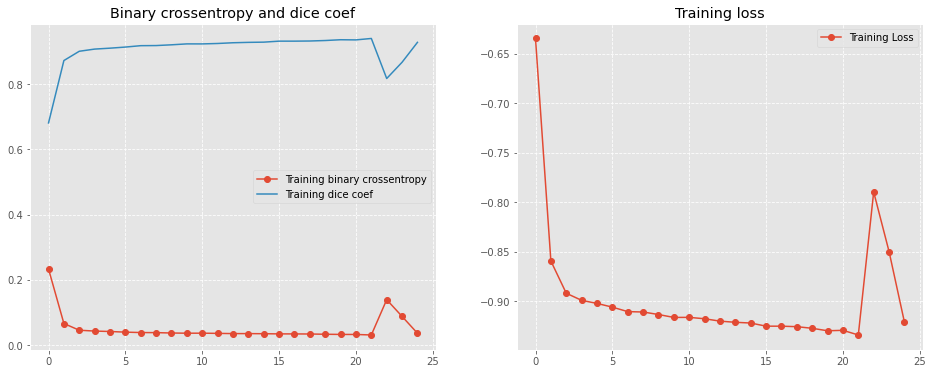

In [ ]:
plot_model_history_dice(history_unet_model_lava)

In [10]:
test_pred_unet_model_lava = unet_model_lava.predict(predict_generator(imagePaths_test), steps=len(imagePaths_test))

test_pred_unet_model_lava = np.squeeze(test_pred_unet_model_lava)

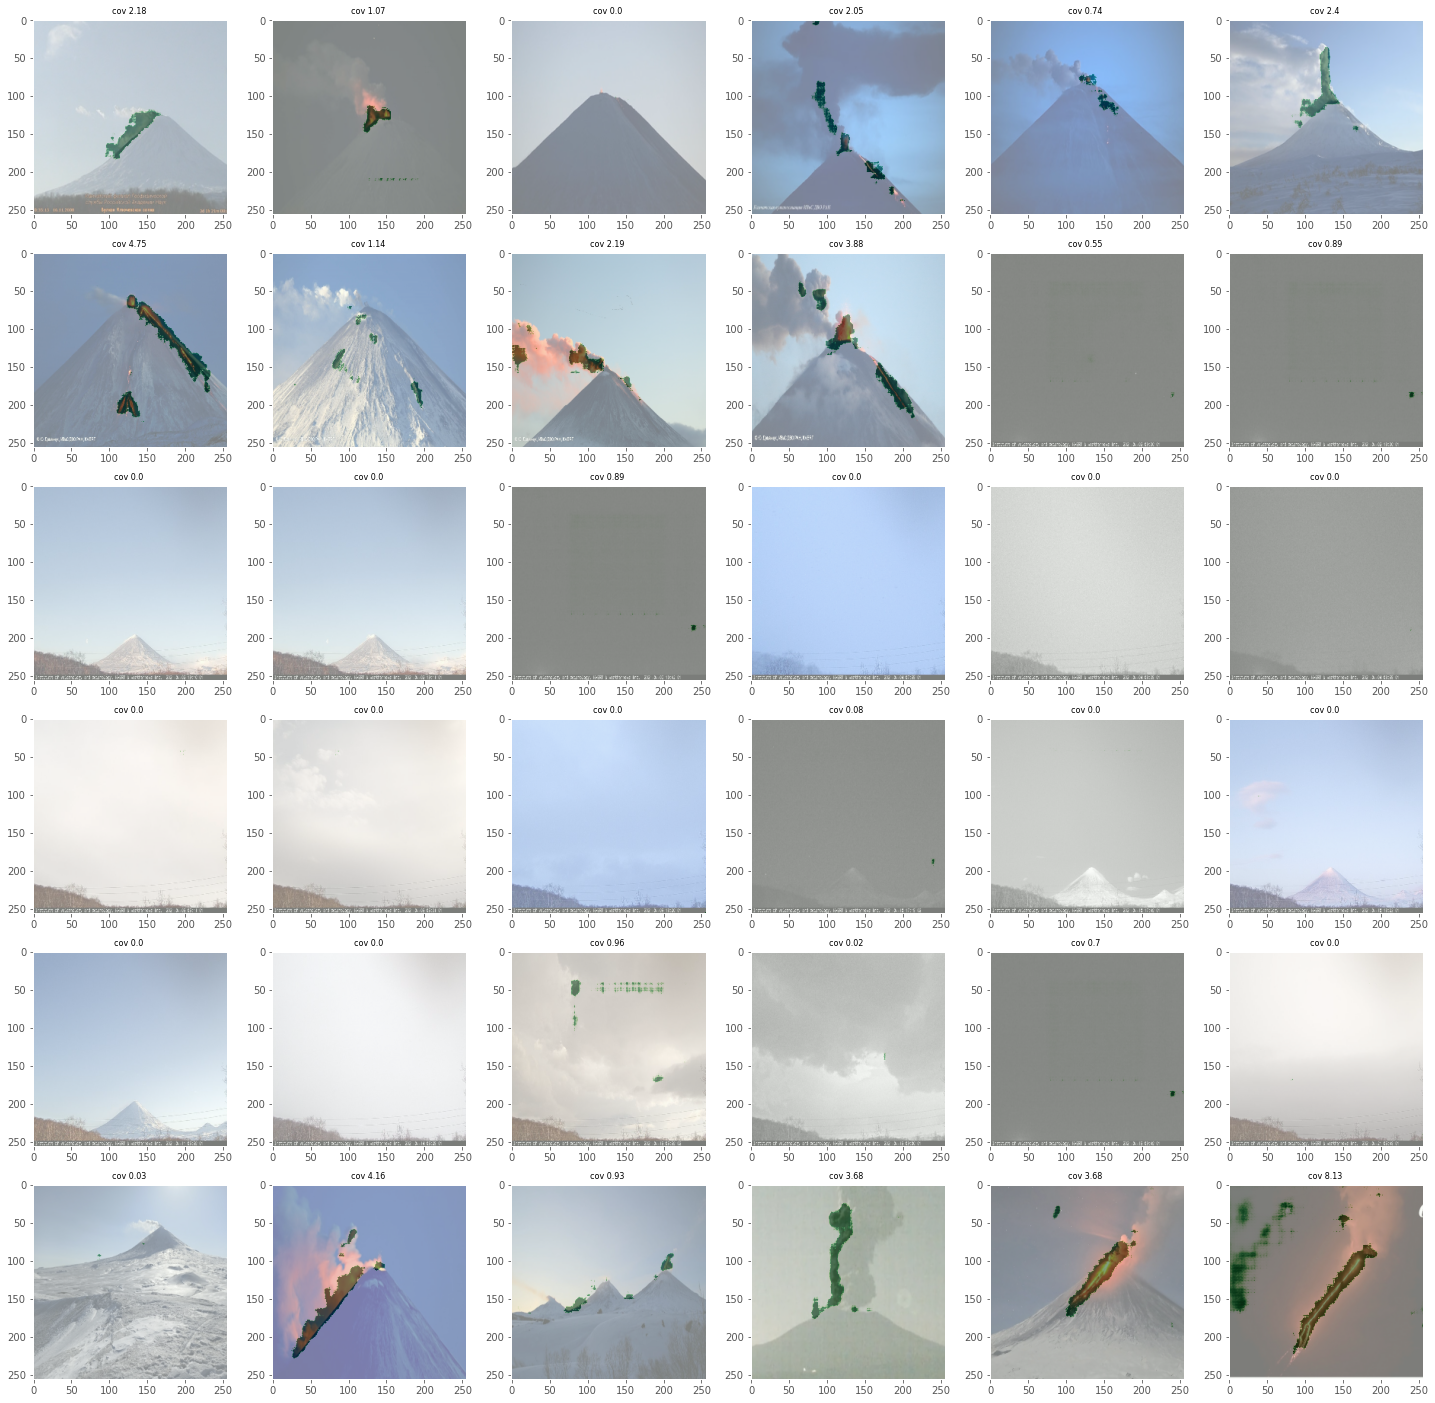

In [25]:
show_images_predict_mask(imagePaths_test,test_pred_unet_model_lava, 6, 6)

В моделях на классификацию точность выше, поэтому если на картинке выделены  сегментированные области,  надо проверять определен ли этот класс в предудущих моделях

In [35]:
unet_model_lava.save(path.join(project_path,'models/unet_model_lava.h5'))
unet_model_pillar.save(path.join(project_path,'models/unet_model_pillar.h5'))

Расчет процента  покрытия изображения маской ко всей площади изображения 

и выделение классов покрытия (пока не используется)

In [32]:
covarage_pillar = [np.sum(sq)/ pow(256, 2) for sq in test_pred_unet_model_pillar]
covarage_lava = [np.sum(sq)/ pow(256, 2) for sq in test_pred_unet_model_lava]

In [33]:
covarage_lava

[0.02178286947309971,
 0.010722647421061993,
 6.280530669755535e-06,
 0.02047264575958252,
 0.007426195312291384,
 0.024039240553975105,
 0.047462910413742065,
 0.011398824863135815,
 0.02188543975353241,
 0.038779549300670624,
 0.005521333310753107,
 0.008907409384846687,
 3.547255982994102e-05,
 3.145094888168387e-05,
 0.00889669731259346,
 3.830215572264023e-18,
 4.078516635530605e-09,
 3.847028347081505e-05,
 5.254044026514748e-07,
 6.415026291506365e-06,
 2.3071865574755632e-17,
 0.0008058355888351798,
 5.634131494680616e-10,
 6.420995513582847e-15,
 9.343805026582053e-13,
 1.7557788556388232e-09,
 0.00958088506013155,
 0.00019659279496409,
 0.0069613391533494,
 1.6570574246088654e-08,
 0.0002698965254239738,
 0.04162241145968437,
 0.00931713916361332,
 0.03677903860807419,
 0.03678596392273903,
 0.08131128549575806,
 0.01411883719265461,
 2.2555177565664053e-06,
 7.252376235555857e-06,
 0.015951987355947495,
 9.023580900503411e-15,
 4.077243517314198e-21,
 0.000428265193477273,
 

In [34]:
covarage_pillar

[0.01358854491263628,
 0.06874290853738785,
 0.00495881075039506,
 0.12298478931188583,
 0.053269386291503906,
 0.07579385489225388,
 0.12223530560731888,
 0.08223555237054825,
 0.0032505777198821306,
 0.05651821196079254,
 0.01689700037240982,
 0.012893899343907833,
 0.0028712518978863955,
 0.0027311460580676794,
 0.01396212074905634,
 4.800489250555984e-08,
 0.011047997511923313,
 0.0007964681135490537,
 0.04432470723986626,
 0.04206528514623642,
 1.014439021673752e-07,
 0.006009365431964397,
 0.0967351421713829,
 0.02295053005218506,
 0.004134788643568754,
 0.02935129962861538,
 0.16594786942005157,
 0.17781586945056915,
 0.012613694183528423,
 0.03022560477256775,
 0.1084403321146965,
 0.09419594705104828,
 0.0029829179402440786,
 0.17378941178321838,
 0.10719001293182373,
 0.035250451415777206,
 0.025956464931368828,
 0.01589949242770672,
 0.0036212147679179907,
 0.038801707327365875,
 0.00309942290186882,
 1.4123750169403593e-08,
 0.0013385976199060678,
 0.08123993873596191,
 0.0

In [16]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        


Text(0.5, 0, 'Coverage class')

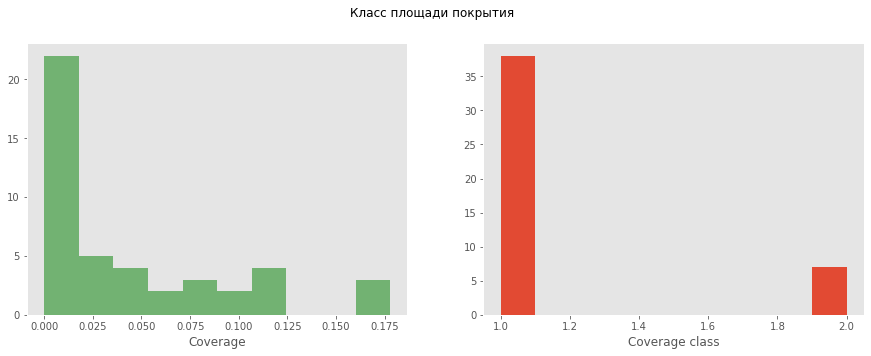

In [36]:
coverage_class =  [cov_to_class(cov) for cov in covarage_pillar]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].hist(covarage_pillar, facecolor='g', alpha=0.5)
axs[1].hist(coverage_class)
plt.suptitle("Класс площади покрытия")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5, 0, 'Coverage class')

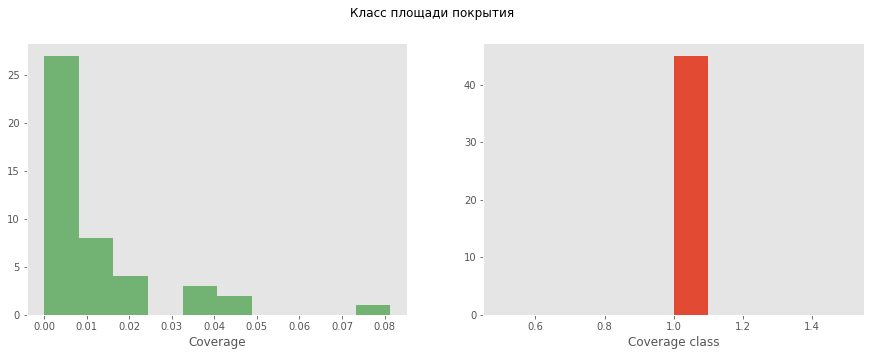

In [20]:
coverage_class =  [cov_to_class(cov) for cov in covarage_lava]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].hist(covarage_lava, facecolor='g', alpha=0.5)
axs[1].hist(coverage_class)
plt.suptitle("Класс площади покрытия")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

## 4.4 Оценка моделей


In [ ]:
classifiers = {
  'ResNet_model_lava': history_ResNet_lava,
  'ResNet_model_pillar': history_ResNet_model_pillar,
  'VGG_model_lava': history_VGG_lava,
  'VGG_model_pillar': history_VGG_pillar
}
classifiers_unet = {
  'unet_model_lava': history_unet_model_lava,
  'unet_model_pillar': history_unet_model_pillar
}

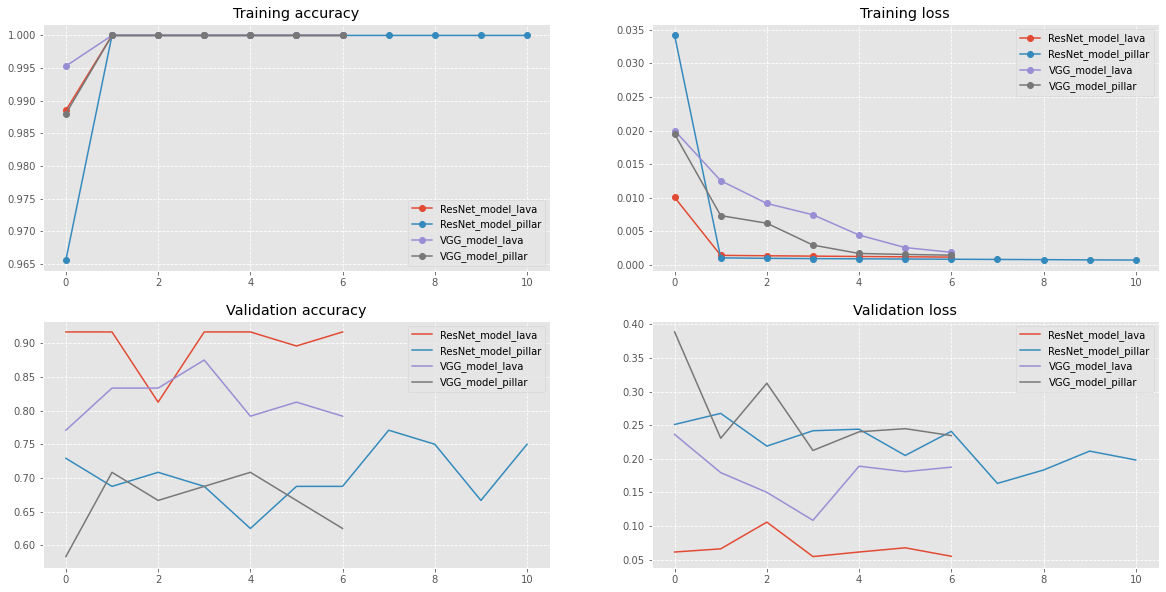

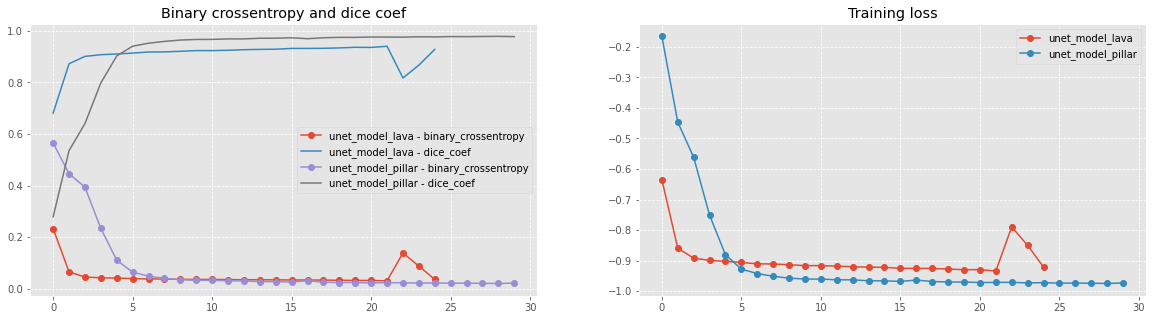

In [ ]:
# Getting the accuracy and loss
result_ml = pd.DataFrame()
fig = plt.figure(figsize=(20, 10))
for model_history in classifiers.items():
      acc = model_history[1].history['accuracy']
      val_acc = model_history[1].history['val_accuracy']
      loss = model_history[1].history['loss']
      val_loss = model_history[1].history['val_loss']
      
      result_ml = result_ml.append({'model' : 'NN',
                              'classifier' : model_history[0],
                              'val accuracy' : val_acc,
                              'train accuracy' : acc,
                              'train loss' : loss,
                              'val loss' : val_loss,
                              } ,  ignore_index=True)

      epochs = range(len(acc))

      subplot = fig.add_subplot(2, 2, 1)
      subplot.set_title('accuracy')
      plt.plot(epochs, acc, '-o', label=model_history[0])
      plt.title('Training accuracy')
      plt.legend()
      plt.grid(linestyle='--')

      subplot = fig.add_subplot(2, 2, 3)
      subplot.set_title('accuracy')
      plt.plot(epochs, val_acc, '-', label=model_history[0])
      plt.title('Validation accuracy')
      plt.legend()
      plt.grid(linestyle='--')

      subplot = fig.add_subplot(2, 2, 2)
      subplot.set_title('loss')
      plt.plot(epochs, loss, '-o', label=model_history[0] )
      plt.title('Training loss')
      plt.legend()
      plt.grid(linestyle='--')

      subplot = fig.add_subplot(2, 2, 4)
      subplot.set_title('loss')
      plt.plot(epochs, val_loss, '-', label=model_history[0])
      plt.title('Validation loss')
      plt.legend()
      plt.grid(linestyle='--')

fig = plt.figure(figsize=(20, 5))
for model_history in classifiers_unet.items():
      acc = model_history[1].history['binary_crossentropy']
      val_acc = model_history[1].history['dice_coef']
      loss = model_history[1].history['loss']
      epochs = range(len(acc))

      result_ml = result_ml.append({'model' : 'NN',
                              'classifier' : model_history[0],
                              'train loss' : loss,
                              'binary_crossentropy' : acc,
                              'dice_coef' : val_acc,
                               } ,  ignore_index=True)

    
      subplot = fig.add_subplot(1, 2, 1)
      subplot.set_title('accuracy')
      plt.plot(epochs, acc, '-o', label=model_history[0]+' - binary_crossentropy')
      plt.plot(epochs, val_acc, '-', label=model_history[0]+' - dice_coef')
      plt.title('Binary crossentropy and dice coef')
      plt.grid(linestyle='--')
      plt.legend()

      subplot = fig.add_subplot(1, 2, 2)
      subplot.set_title('loss')
      plt.plot(epochs, loss, '-o', label=model_history[0] )
      plt.title('Training loss')
      plt.legend()
      plt.grid(linestyle='--')
  
  
plt.show()


In [100]:
test_pred_df = pd.DataFrame()
for i, p in enumerate(imagePaths_test, 0):
        test_pred_df = test_pred_df.append(
                              {'filename' : p.split(os.path.sep)[-1],
                              'image' : np.array(load_image(p)),
                              'pred_ResNet_model_lava' : test_pred_ResNet_model_lava.flatten()[i],
                              'pred_ResNet_model_pillar' : test_pred_ResNet_model_pillar.flatten()[i],
                              'pred_vgg_model_lava' : test_pred_VGG_model_lava.flatten()[i],
                              'pred_vgg_model_pillar' : test_pred_VGG_model_pillar.flatten()[i],
                              'mask_lava' : np.array(test_pred_unet_model_lava[i]),
                              'mask_pillar' : np.array(test_pred_unet_model_pillar[i])
                               } ,  ignore_index=True)
        

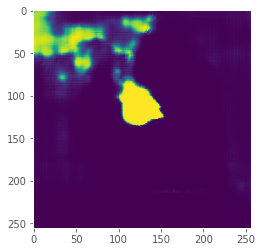

In [ ]:
plt.imshow(test_pred_df['mask_pillar'][1])

Сохраняем результат предсказания для дальнейшего анализа и визуализации

In [ ]:
test_pred_df.to_pickle(path.join(project_path,'data/processed/test_pred.pkl'))


In [77]:
test_pred_df.head(3)

filename  ... pred_vgg_model_pillar
0  1102.jpg  ...              0.263951
1  1142.jpg  ...              0.237128
2  1144.jpg  ...              0.076220

[3 rows x 8 columns]

In [ ]:
y_test_pred_df = test_pred_df
y_test_pred_df = y_test_pred_df.drop(columns=['image', 'mask_lava','mask_pillar'])

In [ ]:
y_test_pred_df.to_csv('predict.csv')

In [45]:
pillar = [1,1,0,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0] 
lava = [0,1,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0] 


In [78]:
y_true = pillar 
y_pred = test_pred_df['pred_ResNet_model_pillar']


print('F1 : %s' % f1_score(y_true, y_pred.round(), average='weighted'))
print('Precision : %s' % precision_score(y_true, y_pred.round(), average='weighted')) 
print('Accuracy: %s' % accuracy_score(y_true, y_pred.round()))
print('Recall: %s' % recall_score(y_true, y_pred.round()))
confusion_matrix(y_true,  y_pred.round())

F1 : 0.6758141762452107
Precision : 0.6895299145299145
Accuracy: 0.6888888888888889
Recall: 0.47368421052631576


array([[22,  4],
       [10,  9]])

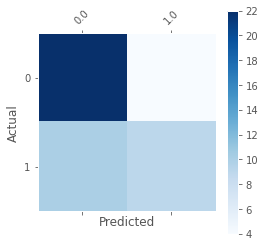

In [79]:
y_true = pd.Series(y_true, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_true, y_pred.round())
plot_confusion_matrix(df_confusion)

In [82]:
y_true = pillar 
y_pred = test_pred_df['pred_vgg_model_pillar']

print('F1 : %s' % f1_score(y_true, y_pred.round(), average='weighted'))
print('Precision : %s' % precision_score(y_true, y_pred.round(), average='weighted')) 
print('Accuracy: %s' % accuracy_score(y_true, y_pred.round()))
print('Recall: %s' % recall_score(y_true, y_pred.round()))
confusion_matrix(y_true,  y_pred.round())

F1 : 0.7072196620583717
Precision : 0.7765432098765431
Accuracy: 0.7333333333333333
Recall: 0.42105263157894735


array([[25,  1],
       [11,  8]])

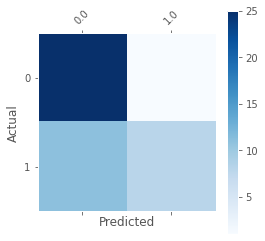

In [83]:
y_true = pd.Series(y_true, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_true, y_pred.round())
plot_confusion_matrix(df_confusion)

In [101]:
y_true = lava 
y_pred = test_pred_df['pred_ResNet_model_lava']


print('F1 : %s' % f1_score(y_true, y_pred.round(), average='weighted'))
print('Precision : %s' % precision_score(y_true, y_pred.round(), average='weighted')) 
print('Accuracy: %s' % accuracy_score(y_true, y_pred.round()))
print('Recall: %s' % recall_score(y_true, y_pred.round()))
confusion_matrix(y_true,  y_pred.round())

F1 : 0.9322291235334714
Precision : 0.9323809523809523
Accuracy: 0.9333333333333333
Recall: 0.8181818181818182


array([[33,  1],
       [ 2,  9]])

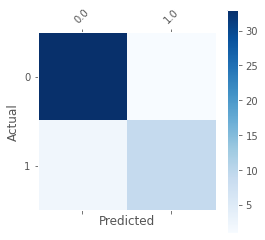

In [102]:
y_true = pd.Series(y_true, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_true, y_pred.round())
plot_confusion_matrix(df_confusion)

In [103]:
y_true = lava 
y_pred = test_pred_df['pred_vgg_model_lava']

print('F1 : %s' % f1_score(y_true, y_pred.round(), average='weighted'))
print('Precision : %s' % precision_score(y_true, y_pred.round(), average='weighted')) 
print('Accuracy: %s' % accuracy_score(y_true, y_pred.round()))
print('Recall: %s' % recall_score(y_true, y_pred.round()))
confusion_matrix(y_true,  y_pred.round())

F1 : 0.8326676907322069
Precision : 0.8723622782446311
Accuracy: 0.8222222222222222
Recall: 0.9090909090909091


array([[27,  7],
       [ 1, 10]])

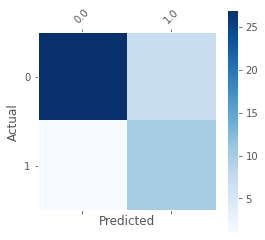

In [104]:
y_true = pd.Series(y_true, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_true, y_pred.round())
plot_confusion_matrix(df_confusion)

In [70]:
pred_df = pd.DataFrame(covarage_pillar)
pred_df = pred_df*10   # если площадь маски больше 10% от изображения, считаем что класс лавы определен
pred_df = pred_df.round()
pred_df = pred_df / pred_df
pred_df = pred_df.fillna(0)

y_true = pillar 
y_pred = pred_df

print('F1 : %s' % f1_score(y_true, y_pred.round(), average='weighted'))
print('Precision : %s' % precision_score(y_true, y_pred.round(), average='weighted')) 
print('Accuracy: %s' % accuracy_score(y_true, y_pred.round()))
print('Recall: %s' % recall_score(y_true, y_pred.round()))
confusion_matrix(y_true,  y_pred.round())

F1 : 0.7271708683473387
Precision : 0.7333333333333333
Accuracy: 0.7333333333333333
Recall: 0.5789473684210527


array([[22,  4],
       [ 8, 11]])

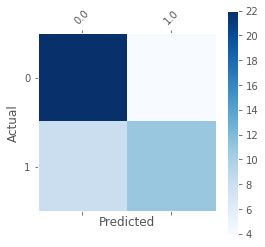

In [71]:
y_true = pd.Series(y_true, name='Actual')
y_pred = pd.Series(pred_df[0], name='Predicted')
df_confusion = pd.crosstab(y_true, y_pred.round())
plot_confusion_matrix(df_confusion)

In [67]:
pred_df = pd.DataFrame(covarage_lava)
pred_df = pred_df*10   # если площадь маски больше 10% от изображения, считаем что класс лавы определен
pred_df = pred_df.round()
pred_df = pred_df / pred_df
pred_df = pred_df.fillna(0)

y_true = lava 
y_pred = pred_df

print('F1 : %s' % f1_score(y_true, y_pred.round(), average='weighted'))
print('Precision : %s' % precision_score(y_true, y_pred.round(), average='weighted')) 
print('Accuracy: %s' % accuracy_score(y_true, y_pred.round()))
print('Recall: %s' % recall_score(y_true, y_pred.round()))
confusion_matrix(y_true,  y_pred.round())

F1 : 0.6994301994301995
Precision : 0.8282828282828283
Accuracy: 0.7777777777777778
Recall: 0.09090909090909091


array([[34,  0],
       [10,  1]])

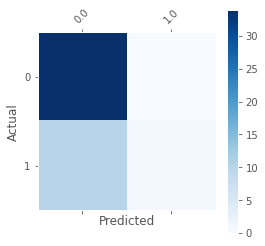

In [69]:
y_true = pd.Series(y_true, name='Actual')
y_pred = pd.Series(pred_df[0], name='Predicted')
df_confusion = pd.crosstab(y_true, y_pred.round())
plot_confusion_matrix(df_confusion)

# Deployment

Обработка входного изображения и выдача результата:

In [9]:
ResNet_model_lava = tf.keras.models.load_model(path.join(project_path,'models/resnet_model_lava.h5'))
ResNet_model_pillar= tf.keras.models.load_model(path.join(project_path,'models/resnet_model_pillar.h5'))

VGG_model_lava= tf.keras.models.load_model(path.join(project_path,'models/vgg_model_lava.h5'))
VGG_model_pillar= tf.keras.models.load_model(path.join(project_path,'models/vgg_model_pillar.h5'))

unet_model_lava= tf.keras.models.load_model(path.join(project_path,'models/unet_model_lava.h5'), compile=False, options=None)
unet_model_pillar= tf.keras.models.load_model(path.join(project_path,'models/unet_model_pillar.h5'), compile=False, options=None)

Predictions probabilities Resnet - VGG:
activity class
pillar -  [0.999] -  [0.992]
lava   -  [0.002] -  [0.002]
Predictions probability mask and
coverage pillar -  0.362 %
coverage lava  -  0.001 %


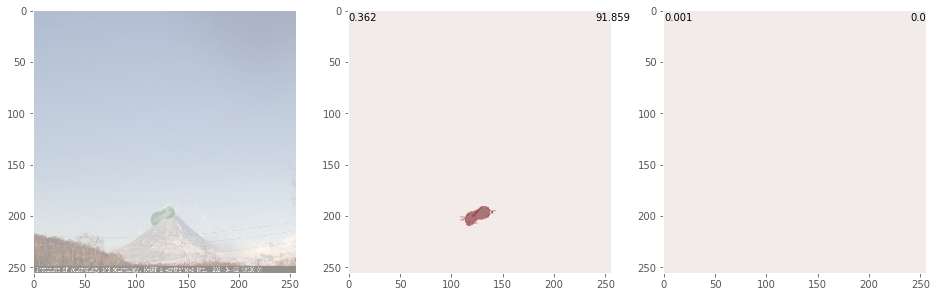

In [106]:
imagePaths = [path.join(project_path,'data/raw/img/img.jpg')]
images_ds = predict_generator(imagePaths)

fig = plt.figure(figsize=(16, 8))
for i in range(len(imagePaths)): 

  image = next(images_ds)

  y_pred_resnet_pillar = ResNet_model_pillar.predict(image)

  y_pred_resnet_lava = ResNet_model_lava.predict(image)

  y_pred_vgg_pillar = VGG_model_pillar.predict(image)

  y_pred_vgg_lava = VGG_model_lava.predict(image)

  y_pred_pillar = unet_model_pillar.predict(image)
  y_pred_pillar = np.squeeze(y_pred_pillar)

  y_pred_lava = unet_model_lava.predict(image)
  y_pred_lava = np.squeeze(y_pred_lava)


  subplot = fig.add_subplot(1, 3, 1)
  coverage_pillar = np.round(np.sum(y_pred_pillar)/ pow(256, 2) * 100 , 3) 
  coverage_lava = np.round(np.sum(y_pred_lava)/ pow(256, 2) * 100 , 3) 
  #image = load_image(imagePaths[i])
  plt.imshow(image[0])

  print('Predictions probabilities Resnet - VGG:')
  print('activity class')
  print('pillar - ',np.round(y_pred_resnet_pillar[0],3),'- ',np.round(y_pred_vgg_pillar[0],3))
  print('lava   - ',np.round(y_pred_resnet_lava[0],3),'- ',np.round(y_pred_vgg_lava[0],3))

  plt.imshow(y_pred_pillar, cmap='Greens', alpha=0.3)
  plt.imshow(y_pred_lava, cmap='Reds', alpha=0.4)
  print('Predictions probability mask and')
  print('coverage pillar - ',coverage_pillar,'%')
  print('coverage lava  - ',coverage_lava,'%')

  subplot1 = fig.add_subplot(1, 3, 2)
  show_mask_gradient(y_pred_pillar, subplot1)

  subplot2 = fig.add_subplot(1, 3, 3)
  show_mask_gradient(y_pred_lava, subplot2)

  fig.show()


Predictions probabilities Resnet - VGG:
activity class
pillar -  [0.999] -  [0.992]
lava   -  [0.999] -  [0.992]
Predictions probability mask and
coverage pillar -  0.001 %
coverage lava  -  0.001 %


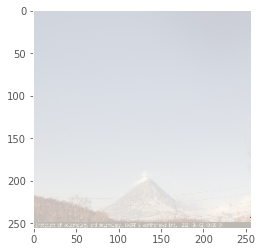

Predictions probabilities Resnet - VGG:
activity class
pillar -  [0.734] -  [0.514]
lava   -  [0.734] -  [0.514]
Predictions probability mask and
coverage pillar -  1.595 %
coverage lava  -  1.595 %


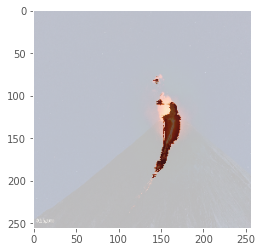

In [ ]:
imagePaths = [path.join(project_path,'data/raw/img/img.jpg'),path.join(project_path,'data/raw/img/img2.jpg')]
images_ds = predict_generator(imagePaths)


for i in range(len(imagePaths)): 
  image = next(images_ds)

  y_pred_resnet_pillar = ResNet_model_pillar.predict(image)

  y_pred_resnet_lava = ResNet_model_lava.predict(image)

  y_pred_vgg_pillar = VGG_model_pillar.predict(image)

  y_pred_vgg_lava = VGG_model_lava.predict(image)


  y_pred_pillar = unet_model_pillar.predict(image)
  y_pred_pillar = np.squeeze(y_pred_pillar)
  
  y_pred_lava = unet_model_lava.predict(image)
  y_pred_lava = np.squeeze(y_pred_lava)
  
  score_pillar = y_pred_pillar 
  score_lava = y_pred_lava 
  coverage_pillar = np.round(np.sum(score_pillar)/ pow(256, 2) * 100 , 3) 
  coverage_lava = np.round(np.sum(score_lava)/ pow(256, 2) * 100 , 3) 
  print('Predictions probabilities Resnet - VGG:')
  print('activity class')
  print('pillar - ',np.round(y_pred_resnet_pillar[0],3),'- ',np.round(y_pred_vgg_pillar[0],3))
  print('lava   - ',np.round(y_pred_resnet_lava[0],3),'- ',np.round(y_pred_vgg_lava[0],3))
  
  print('Predictions probability mask and')
  print('coverage pillar - ',coverage_pillar,'%')
  print('coverage lava  - ',coverage_lava,'%')

  #plt.imshow(load_image(imagePaths[i]), cmap='gray');
  plt.imshow(image[0])
  plt.imshow(score_pillar, cmap='Greens', alpha=0.5)
  plt.imshow(score_lava, cmap='Reds', alpha=0.5)
  plt.show()

Predictions probability mask and
coverage pillar -  0.001 %
coverage lava  -  0.001 %


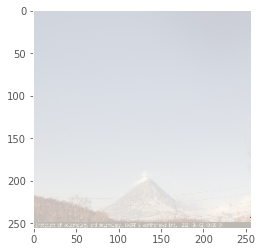

Predictions probability mask and
coverage pillar -  1.595 %
coverage lava  -  1.595 %


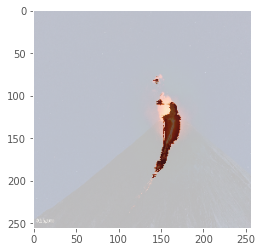

In [ ]:
imagePaths = [path.join(project_path,'data/raw/img/img.jpg'),path.join(project_path,'data/raw/img/img2.jpg')]
images_ds = predict_generator(imagePaths)

y_pred_pillar = unet_model_pillar.predict(images_ds, steps=len(imagePaths))
y_pred_pillar = np.squeeze(y_pred_pillar)

images_ds = predict_generator(imagePaths)

y_pred_lava = unet_model_lava.predict(images_ds, steps=len(imagePaths))
y_pred_lava = np.squeeze(y_pred_lava)

for i in range(len(imagePaths)): 

  
  score_pillar = y_pred_pillar[i] 
  score_lava = y_pred_lava[i] 
  coverage_pillar = np.round(np.sum(score_pillar)/ pow(256, 2) * 100 , 3) 
  coverage_lava = np.round(np.sum(score_lava)/ pow(256, 2) * 100 , 3) 

  print('Predictions probability mask and')
  print('coverage pillar - ',coverage_pillar,'%')
  print('coverage lava  - ',coverage_lava,'%')

  plt.imshow(load_image(imagePaths[i]), cmap='gray');
  plt.imshow(score_pillar, cmap='Greens', alpha=0.5)
  plt.imshow(score_lava, cmap='Reds', alpha=0.5)
  plt.show()


# TODO


- проверить влияние аугментацию
- проверить влияние перевода в ЧБ исходное изображение для лавы ночью?

